In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import opening, disk

In [2]:
image_root = "data/images"
mask_root  = "data/masks"

In [3]:
def dice_score(pred_mask, gt_mask):
    pred_mask = np.asarray(pred_mask, dtype=bool)
    gt_mask = np.asarray(gt_mask, dtype=bool)

    if np.sum(gt_mask) == 0:
        return None

    overlap = np.logical_and(pred_mask, gt_mask).sum()
    total_pixels = pred_mask.sum() + gt_mask.sum()

    return (2.0 * overlap) / (total_pixels + 1e-6)


def jaccard_index(pred_mask, gt_mask):
    pred_mask = np.asarray(pred_mask, dtype=bool)
    gt_mask = np.asarray(gt_mask, dtype=bool)

    if np.sum(gt_mask) == 0:
        return None

    overlap = np.logical_and(pred_mask, gt_mask).sum()
    union_area = np.logical_or(pred_mask, gt_mask).sum()

    return overlap / (union_area + 1e-6)


In [4]:
dice_otsu_scores = []
jaccard_otsu_scores = []

dice_sauvola_scores = []
jaccard_sauvola_scores = []

num_processed = 0
num_skipped = 0


In [5]:
for cls_name in os.listdir(image_root):

    img_cls_path = os.path.join(image_root, cls_name)
    mask_cls_path = os.path.join(mask_root, cls_name)

    if not os.path.isdir(img_cls_path):
        continue

    for filename in os.listdir(img_cls_path):

        img_path = os.path.join(img_cls_path, filename)
        mask_path = os.path.join(mask_cls_path, filename)

        if not os.path.exists(mask_path):
            continue

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        # Convert mask to binary
        mask_bin = (mask > 0).astype(np.uint8)

        # Skip images with no tumor region
        if np.sum(mask_bin) == 0:
            num_skipped += 1
            continue

        num_processed += 1

        # -------- OTSU --------
        otsu_threshold = threshold_otsu(image)
        otsu_seg = image > otsu_threshold

        # -------- SAUVOLA --------
        sauvola_threshold = threshold_sauvola(image, window_size=25, k=0.2)
        sauvola_seg = image > sauvola_threshold

        # Morphological noise removal
        otsu_seg = opening(otsu_seg, disk(2))
        sauvola_seg = opening(sauvola_seg, disk(2))

        # Compute metrics
        dice_otsu_scores.append(dice_score(otsu_seg, mask_bin))
        jaccard_otsu_scores.append(jaccard_index(otsu_seg, mask_bin))

        dice_sauvola_scores.append(dice_score(sauvola_seg, mask_bin))
        jaccard_sauvola_scores.append(jaccard_index(sauvola_seg, mask_bin))


In [6]:
# Remove None values before computing averages
dice_otsu_scores = np.array([d for d in dice_otsu_scores if d is not None])
jaccard_otsu_scores = np.array([j for j in jaccard_otsu_scores if j is not None])

dice_sauvola_scores = np.array([d for d in dice_sauvola_scores if d is not None])
jaccard_sauvola_scores = np.array([j for j in jaccard_sauvola_scores if j is not None])


print(f"Images processed (tumor present): {num_processed}")
print(f"Images skipped (no tumor): {num_skipped}")

print("\n========== FINAL SEGMENTATION RESULTS ==========")

if len(dice_otsu_scores) > 0:
    print(f"Otsu Dice Score       : {dice_otsu_scores.mean():.4f}")
    print(f"Otsu Jaccard Score    : {jaccard_otsu_scores.mean():.4f}")

if len(dice_sauvola_scores) > 0:
    print(f"Sauvola Dice Score    : {dice_sauvola_scores.mean():.4f}")
    print(f"Sauvola Jaccard Score : {jaccard_sauvola_scores.mean():.4f}")


Images processed (tumor present): 1
Images skipped (no tumor): 0

========== FINAL SEGMENTATION RESULTS ==========
Otsu Dice Score       : 0.0681
Otsu Jaccard Score    : 0.0352
Sauvola Dice Score    : 0.0377
Sauvola Jaccard Score : 0.0192


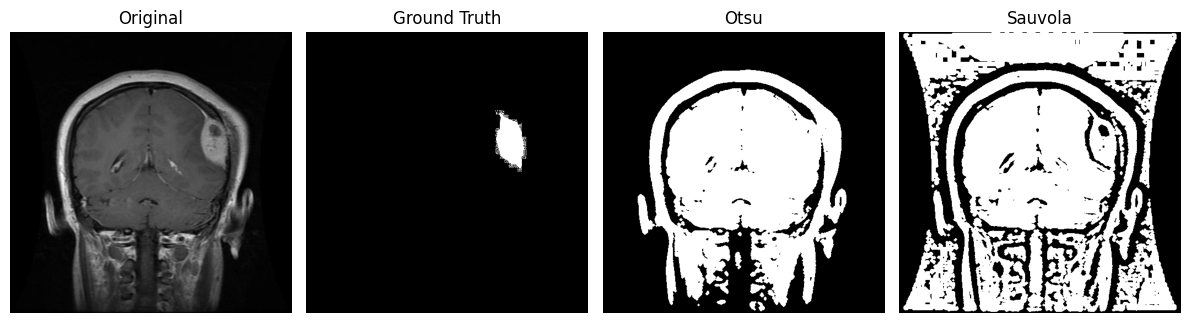

In [7]:
plt.figure(figsize=(12, 4))

titles = ["Original", "Ground Truth", "Otsu", "Sauvola"]
images_to_show = [image, mask_bin, otsu_seg, sauvola_seg]

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_show[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


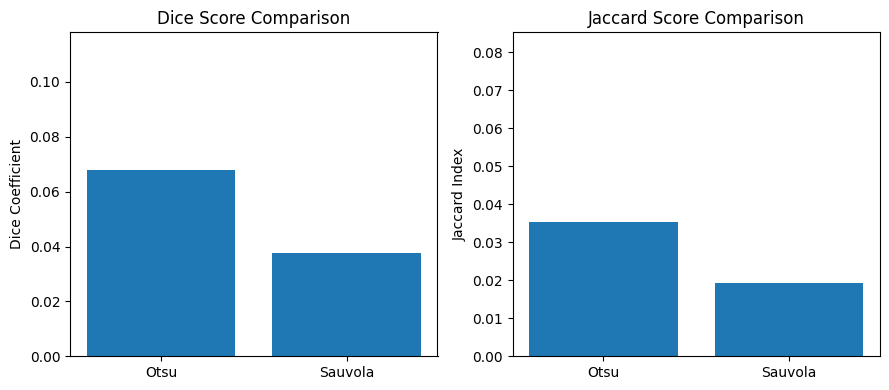

In [9]:
methods = ["Otsu", "Sauvola"]

avg_dice = [
    dice_otsu_scores.mean(),
    dice_sauvola_scores.mean()
]

avg_jaccard = [
    jaccard_otsu_scores.mean(),
    jaccard_sauvola_scores.mean()
]

plt.figure(figsize=(9, 4))

# Dice comparison
plt.subplot(1, 2, 1)
plt.bar(methods, avg_dice)
plt.title("Dice Score Comparison")
plt.ylabel("Dice Coefficient")
plt.ylim(0, max(avg_dice) + 0.05)

# Jaccard comparison
plt.subplot(1, 2, 2)
plt.bar(methods, avg_jaccard)
plt.title("Jaccard Score Comparison")
plt.ylabel("Jaccard Index")
plt.ylim(0, max(avg_jaccard) + 0.05)

plt.tight_layout()
plt.show()
